In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr

import pandas as pd

from vpetabc import *

In [2]:
# 2TCM

df = pd.read_csv("data/sample 2TCM.csv", header=None)

# Duplicate the last row (TAC data) 2 times to create 3 voxels
last_row = df.iloc[-1:].values  # Get the last row as array
duplicated_rows = pd.DataFrame([last_row[0]] * 2, columns=df.columns)
df = pd.concat([df, duplicated_rows], ignore_index=True)

Cp_fine, A, voxel_tacs, t_fine = preprocess_table(df, dt_fine=0.5)  # (T_fine,), (F,T_fine), (V,F)

model  = TwoTissueModel()
lowers = jnp.array([
    0.4,  # K1
    0.3,  # k2
    0.08, # k3
    0,    # k4
    0.01  # Vb
    ])
uppers = jnp.array([
    0.5,  # K1
    0.4,  # k2
    0.09, # k3
    0.1,  # k4
    0.02  # Vb
    ])
abc    = ABCRejection(model,
                        prior_sampler=TwoTissuePrior,
                        lower_bounds=lowers,
                        upper_bounds=uppers,
                        num_sims=1_000_000,
                        accept_frac=48/1_000_000)

seed = 2025
key   = jr.PRNGKey(seed)
posterior = abc.run(key,
                    voxel_tacs,        # observed shape (F,)
                    Cp_fine,
                    A,                 # maps fine grid → frames
                    dt=0.5,            # time step for explicit Euler
                    batch_size=50_000, # number of simulations per batch
                    progress=True)
conditional_posterior_mean, preferred_model = get_conditional_posterior_mean(posterior)
print("Posterior:", posterior.shape, "\nPreferred model:", preferred_model.shape, "\nConditional mean:", conditional_posterior_mean.shape)

Running ABC:   0%|          | 0/1000000 [00:00<?, ?it/s]

Posterior: (3, 48, 6) 
Preferred model: (3,) 
Conditional mean: (3, 6)


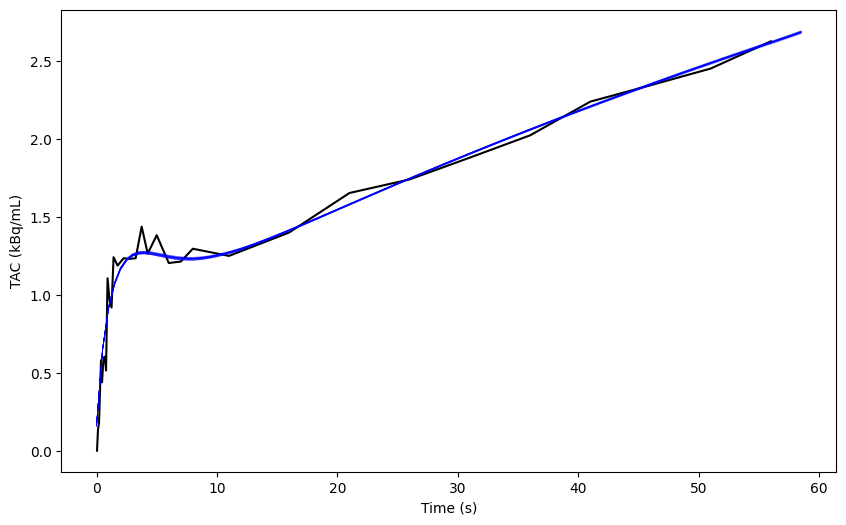

In [3]:
voxel = 0
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[0], df.iloc[3 + voxel], label='Observed TAC', color='black')
for i in range(posterior.shape[1]):
    colour = "red" if posterior[voxel, i][-1] else "blue"
    plt.plot(t_fine, model.simulate(posterior[voxel, i], Cp_fine, dt=0.5), alpha=0.2, linewidth=0.5, color=colour)
plt.xlabel('Time (s)')
plt.ylabel('TAC (kBq/mL)')
plt.show()

In [4]:
# lp-ntPET / MRTM

df = pd.read_csv("data/sample lpntPET.csv", header=None)

Cr_fine, A, voxel_tacs, t_fine = preprocess_table(df, dt_fine=0.5)  # (T_fine,), (F,T_fine), (V,F)

model  = lpntPETModel()
lowers = jnp.array([
    0.4, # R1
    0.,  # k2
    0.,  # k2a
    0.,  # gamma
    15., # tD
    1.,  # tP - tD
    0.   # alpha
    ])
uppers = jnp.array([
    1.6, # R1
    0.6, # k2
    0.2, # k2a
    0.2, # gamma
    25., # tD
    45., # tP - tD
    4.   # alpha
    ])
abc    = ABCRejection(model,
                        prior_sampler=lpntPETPrior,
                        lower_bounds=lowers,
                        upper_bounds=uppers,
                        num_sims=5_000_000,
                        accept_frac=10/5_000_000)

seed  = 2025
key   = jr.PRNGKey(seed)
posterior = abc.run(key,
                    voxel_tacs,          # observed shape (F,)
                    Cr_fine,
                    A,                   # maps fine grid → frames
                    dt=0.5,              # time step for explicit Euler
                    batch_size=50_000,   # number of simulations per batch
                    progress=True)
conditional_posterior_mean, preferred_model = get_conditional_posterior_mean(posterior)
print("Posterior:", posterior.shape, "\nPreferred model:", preferred_model.shape, "\nConditional mean:", conditional_posterior_mean.shape)

Running ABC:   0%|          | 0/5000000 [00:00<?, ?it/s]

Posterior: (2, 10, 8) 
Preferred model: (2,) 
Conditional mean: (2, 8)


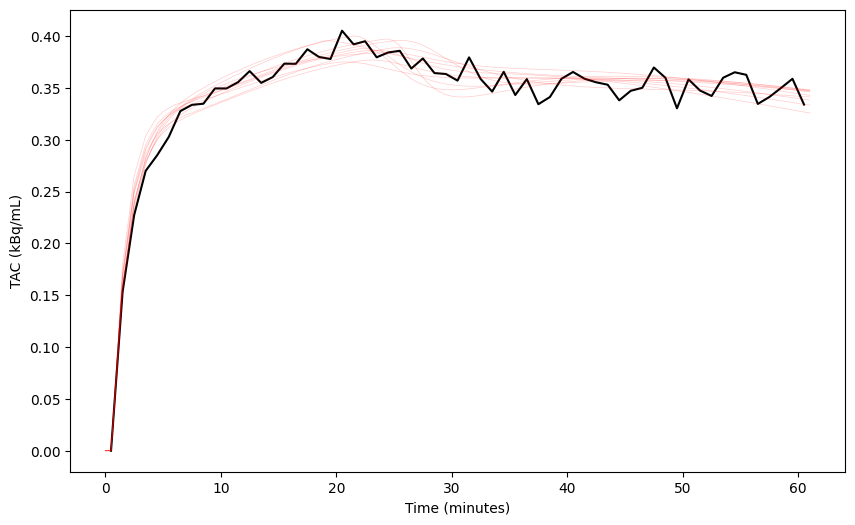

In [5]:
voxel = 0
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[0], df.iloc[3 + voxel], label='Observed TAC', color='black')
for i in range(posterior.shape[1]):
    colour = "red" if posterior[voxel, i][-1] else "blue"
    plt.plot(t_fine, model.simulate(posterior[voxel, i], Cr_fine, dt=0.5), alpha=0.2, linewidth=0.5, color=colour)
plt.xlabel('Time (minutes)')
plt.ylabel('TAC (kBq/mL)')
plt.show()